# 시뮬레이션
몬테카를로 시뮬레이션은 금융공학에서 가장 중요하고 널리 쓰이는 수치해석 방법 중의 하나 이다. 그 이유는 몬테카를로 시뮬레이션이 적분 등의 수학식이나 금융 파생상품의 가치를 계산할 때 가장 유연한 수치 해석 방법론이기 때문이다. 유연한 대신 상대적으로 계산 부담은 크다. 하나의 값을 추정하기 위해 수백, 수천 혹은 수백만의 복잡한 계산을 해야한다.

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline

## 확률 변수

In [17]:
s0 = 100 #초기값
r = 0.05 # 고정 단기 이자율
sigma = 0.25 # 고정 변동성
T = 2.0 #연단위
I = 10000 # 난수 개수
# 브라운모션 모형을 이용한 주가시뮬레이션
sT1 = s0 * np.exp((r-0.5*sigma**2)*T 
                 + sigma*np.sqrt(T)*npr.standard_normal(I))


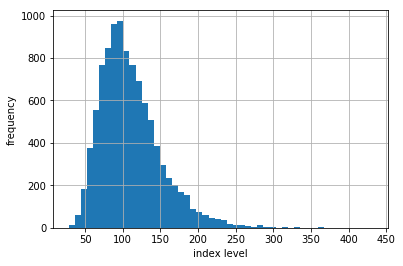

In [18]:
plt.hist(sT1, bins=50)
plt.xlabel('index level')
plt.ylabel('frequency')
plt.grid(True)

In [19]:
#로그 분포의 형식으로
sT2 = s0 * npr.lognormal((r-0.5*sigma**2)*T 
                 , sigma*np.sqrt(T), size=I)

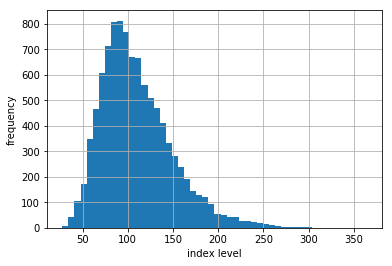

In [20]:
plt.hist(sT2, bins=50)
plt.xlabel('index level')
plt.ylabel('frequency')
plt.grid(True)

In [7]:
# 시뮬레이션 결과의 통계특성을 비교해보자
import scipy.stats as scs

In [15]:
def print_statistics(a1, a2):
    sta1 = scs.describe(a1)
    sta2 = scs.describe(a2)
    print ("%14s %14s %14s" %\
           ('statistic', 'data set 1', 'data set 2'))
    print (45 *"-")
    print ("%14s %14.3f %14.3f" % ('size', sta1[0], sta2[0]))
    print ("%14s %14.3f %14.3f" % ('min', sta1[1][0], sta2[1][0]))
    print ("%14s %14.3f %14.3f" % ('max', sta1[1][1], sta2[1][1]))
    print ("%14s %14.3f %14.3f" % ('mean', sta1[2], sta2[2]))
    print ("%14s %14.3f %14.3f" % ('std', np.sqrt(sta1[3]), np.sqrt(sta2[3])))
    print ("%14s %14.3f %14.3f" % ('skew', sta1[4], sta2[4]))
    print ("%14s %14.3f %14.3f" % ('kurtosis', sta1[5], sta2[5]))
    

In [21]:
print_statistics(sT1, sT2)

     statistic     data set 1     data set 2
---------------------------------------------
          size      10000.000      10000.000
           min         28.129         27.584
           max        432.053        364.328
          mean        110.443        110.249
           std         40.371         39.829
          skew          1.167          1.048
      kurtosis          2.519          1.697


## 확률 과정

### 기하 브라운 운동 모형

In [22]:
I = 10000
M = 50
dt = T / M
S = np.zeros((M+1, I))
S[0] = s0
for t in range(1, M+1):
    S[t] = S[t-1] * np.exp((r - 0.5*sigma**2) *dt
                          + sigma*np.sqrt(dt)*npr.standard_normal(I))

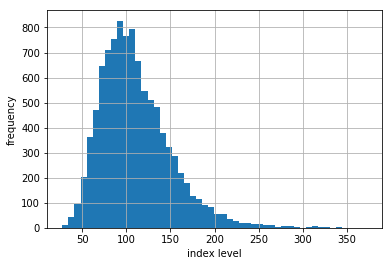

In [23]:
plt.hist(S[-1], bins=50)
plt.xlabel('index level')
plt.ylabel('frequency')
plt.grid(True)

In [24]:
print_statistics(S[-1], sT2)

     statistic     data set 1     data set 2
---------------------------------------------
          size      10000.000      10000.000
           min         27.219         27.584
           max        372.712        364.328
          mean        110.692        110.249
           std         40.421         39.829
          skew          1.185          1.048
      kurtosis          2.596          1.697


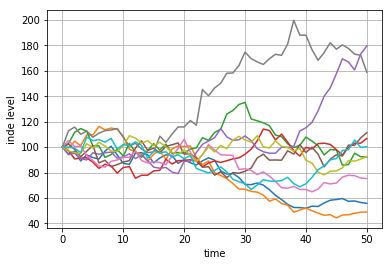

In [25]:
#시뮬레이션 경로 중 10개만 보이기
plt.plot(S[:,:10], lw=1.5)
plt.xlabel('time')
plt.ylabel('inde level')
plt.grid(True)

### 제곱근 확산 모형
단기 이자율이나 변동성 모형에 사용되는 평균 회귀과정에서 가장 널리 사용되는 모형은 Cox-Ingersoll-Ross가 제안한 제곱근 확산모형이다.  
제곱근 확산 과정에 대해서도 정확한 이산 방법이 존재하기는 하지만 오일러 방법을 사용하는 쪽이 계산상 장점이 많다. 이 방식은 full truncation 이산화 방식이라고 불리운다.

In [26]:
x0 = 0.05
kappa = 3.0
theta = 0.02
sigma = 0.1

In [31]:
I = 10000
M = 50
dt = T/M
def srd_euler():
    xh = np.zeros((M+1, I))
    x1 = np.zeros_like(xh)
    xh[0] = x0
    x1[0] = x0
    for t in range(1, M+1):
        xh[t] = (xh[t-1]
                + kappa*(theta - np.maximum(xh[t-1],0))*dt
                + sigma*np.sqrt(np.maximum(xh[t-1],0))*dt
                * npr.standard_normal(I))
    x1 = np.maximum(xh,0)
    return x1
x1 = srd_euler()

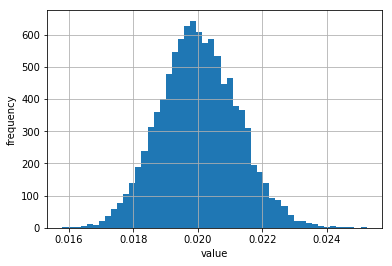

In [32]:
plt.hist(x1[-1], bins=50)
plt.xlabel('value')
plt.ylabel('frequency')
plt.grid(True)

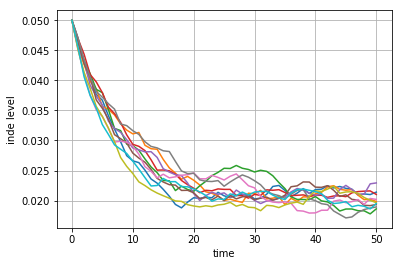

In [34]:
#시뮬레이션 경로 중 10개만 보이기
plt.plot(x1[:,:10], lw=1.5)
plt.xlabel('time')
plt.ylabel('inde level')
plt.grid(True)

In [35]:
# 정확한 이산화 표현 : 자유도와 비중심 인수를 가진 비중심 카이 제곱 분포로 표현한 것.
def srd_exact():
    x2 = np.zeros((M+1, I))
    x2[0] = x0
    for t in range(1, M+1):
        df = 4*theta*kappa / sigma **2
        c = (sigma**2 * (1-np.exp(-kappa*dt))) / (4*kappa)
        nc = np.exp(-kappa*dt)/c *x2[t-1]
        x2[t] = c* npr.noncentral_chisquare(df, nc, size=I)
    return x2
x2 = srd_exact()

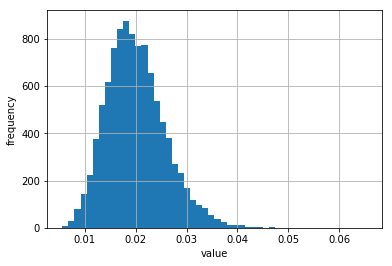

In [36]:
plt.hist(x2[-1], bins=50)
plt.xlabel('value')
plt.ylabel('frequency')
plt.grid(True)

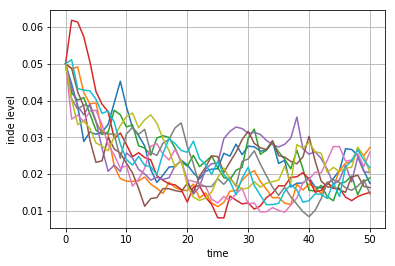

In [37]:
#시뮬레이션 경로 중 10개만 보이기
plt.plot(x2[:,:10], lw=1.5)
plt.xlabel('time')
plt.ylabel('inde level')
plt.grid(True)

In [38]:
print_statistics(x1[-1],x2[-1])

     statistic     data set 1     data set 2
---------------------------------------------
          size      10000.000      10000.000
           min          0.016          0.006
           max          0.025          0.065
          mean          0.020          0.020
           std          0.001          0.006
          skew          0.133          0.637
      kurtosis          0.045          0.971


In [39]:
I = 250000
%time x1 = srd_euler()

Wall time: 2.5 s


In [41]:
%time x2 = srd_exact()

Wall time: 3.14 s


실행 속도 면에서는 비중심 카이 제곱 분포에서 직접 샘플링하는 방식이 표준정규분포를 이용하는 것보다 계산상 부담이 크다.

### 확률적 변동성 모형
일반적으로 변동성은 고정되어 있지도 않고 결정론적이 아닌 확률적인 값이다. 이를 도입한 확률적 변동성 모형 중 가장 인기 있는 모형 중 하나는 헤스톤 모형이다.

In [42]:
s0 = 100.
r = 0.05
v0 = 0.1
kappa = 3.0
theta = 0.25
sigma = 0.1
rho = 0.6
T = 1.0

In [43]:
# 두 확률 과정(주가와 변동성)의 상관관계를 구하려면 상관계수 행렬에 대한 숄레스키 분해가 필요하다
corr_mat = np.zeros((2,2))
corr_mat[0, :] = [1.0, rho]
corr_mat[1, :] = [rho, 1.0]
cho_mat = np.linalg.cholesky(corr_mat)
cho_mat

array([[1. , 0. ],
       [0.6, 0.8]])

In [46]:
M = 50
I = 10000
ran_num = npr.standard_normal((2, M+1, I))

In [47]:
dt = T/M
v = np.zeros_like(ran_num[0])
vh = np.zeros_like(v)
v[0] = v0
vh[0] = v0
for t in range(1, M+1):
    ran = np.dot(cho_mat, ran_num[:,t,:])
    vh[t] = (vh[t-1]
            + kappa*(theta - np.maximum(vh[t-1],0))*dt
            + sigma*np.sqrt(np.maximum(vh[t-1],0))*np.sqrt(dt)
            * ran[1])
v = np.maximum(vh,0)

In [48]:
S = np.zeros_like(ran_num[0])
S[0] = s0
for t in range(1, M+1):
    ran = np.dot(cho_mat, ran_num[:,t,:])
    S[t] = S[t-1]*np.exp((r-0.5*v[t])*dt + 
                        np.sqrt(v[t])*ran[0]*np.sqrt(dt))

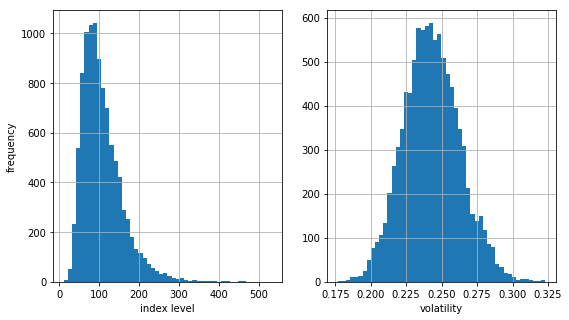

In [49]:
# 주가와 변동성 두 확률 과정을 시뮬레이션한 결과
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,5))
ax1.hist(S[-1], bins=50)
ax1.set_xlabel('index level')
ax1.set_ylabel('frequency')
ax1.grid(True)
ax2.hist(v[-1], bins=50)
ax2.set_xlabel('volatility')
ax2.grid(True)

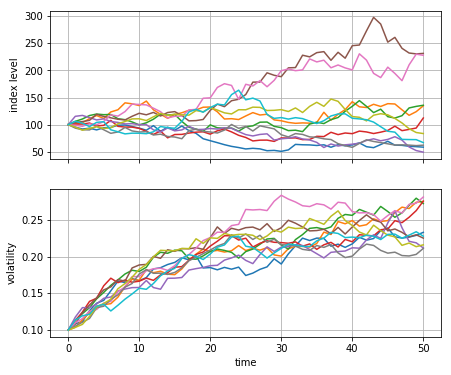

In [50]:
# 확률적 변동성 모형의 시뮬레이션 경로
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True , figsize=(7,6))
ax1.plot(S[:,:10], lw=1.5)
ax1.set_ylabel('index level')
ax1.grid(True)
ax2.plot(v[:,:10], lw=1.5)
ax2.set_xlabel('time')
ax2.set_ylabel('volatility')
ax2.grid(True)

In [51]:
print_statistics(S[-1], v[-1])

     statistic     data set 1     data set 2
---------------------------------------------
          size      10000.000      10000.000
           min         11.419          0.177
           max        530.425          0.323
          mean        107.972          0.243
           std         51.189          0.020
          skew          1.599          0.185
      kurtosis          4.716          0.067


주가의 최대값이 기하 브라운 운동 모형보다 큰것을 알 수있는데, 이는 변동성이 고정값이 아니라 지속적으로 증가하였기 때문이다.

### 점프확산
시장에서 볼 수 있는 또 하나의 특징은 자산 가격이나 변동성이 점프하는 현상이다

In [52]:
s0 = 100
r = 0.05
sigma = 0.2
lamb = 0.75
mu = -0.6
delta = 0.25
T = 1.0

In [53]:
# 점프확산모형을 시뮬레이션하려면 3개의 독립적인 난수 집합이 필요하다.
M = 50
I = 10000
dt = T/M
rj = lamb*(np.exp(mu + 0.5*delta**2)-1)
S= np.zeros((M+1, I))
S[0] = s0
sn1 = npr.standard_normal((M+1, I))
sn2 = npr.standard_normal((M+1, I))
poi = npr.poisson(lamb *dt, (M+1, I))
for t in range(1, M+1, 1):
    S[t] = S[t-1]*(np.exp((r-rj-0.5*sigma**2) *dt
                   + sigma * np.sqrt(dt)*sn1[t])
                   + (np.exp(mu + delta *sn2[t])-1)
                   * poi[t])
    S[t] = np.maximum(S[t],0)
    

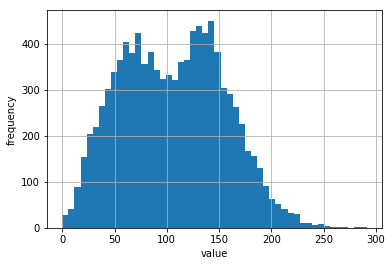

In [54]:
plt.hist(S[-1], bins=50)
plt.xlabel('value')
plt.ylabel('frequency')
plt.grid(True)

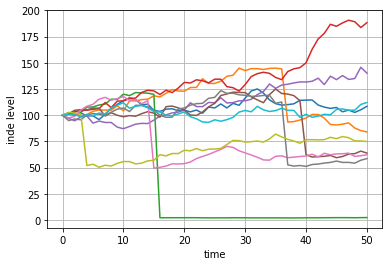

In [55]:
#시뮬레이션 경로 중 10개만 보이기
plt.plot(S[:,:10], lw=1.5)
plt.xlabel('time')
plt.ylabel('inde level')
plt.grid(True)

## 분산감소

In [57]:
print("%15s %15s" % ('Mean','Std. Deviation'))
print(31 *"-")
for i in range(1, 31, 2):
    npr.seed(1000)
    sn = npr.standard_normal(i**2 *10000)
    print("%15.12f %15.12f" % (sn.mean(), sn.std()))

           Mean  Std. Deviation
-------------------------------
-0.011870394558  1.008752430725
-0.002815667298  1.002729536352
-0.003847776704  1.000594044165
-0.003058113374  1.001086345326
-0.001685126538  1.001630849589
-0.001175212007  1.001347684642
-0.000803969036  1.000159081432
-0.000601970954  0.999506522127
-0.000147787693  0.999571756099
-0.000313035581  0.999646153704
-0.000178447061  0.999677277878
 0.000096501709  0.999684346792
-0.000135677013  0.999823841902
-0.000015726986  0.999906493379
-0.000039368519  1.000063091949


In [58]:
i**2 * 10000

8410000

샘플 숫자가 클수록 통계치가 나아지는 것을 알수 있지만, 난수의 수가 8000000개가 넘는 가장 큰 샘플에서도 우리가 원하는 수주에는 도달하지 못했다.

여기서 우리는 처음 두개의 모멘트 값을 개선하고 어렵지 않게 구현할 수 있는 분산 감소 방법이 존재한다. 첫 번째 방법은 대조 변수를 사용하는 것이다. 이 방법은 난수를 원하는 수의 절반만 생성하고 생성된 숫자의 부호를 반대로 한 난수를 추가로 포함하는 방법이다.

In [61]:
sn = npr.standard_normal(5000)
sn = np.concatenate((sn, -sn))
np.shape(sn)

(10000,)

In [62]:
print("%15s %15s" % ('Mean','Std. Deviation'))
print(31 *"-")
for i in range(1, 31, 2):
    npr.seed(1000)
    sn = npr.standard_normal(i**2 *5000)
    sn = np.concatenate((sn,-sn))
    print("%15.12f %15.12f" % (sn.mean(), sn.std()))

           Mean  Std. Deviation
-------------------------------
 0.000000000000  1.009653753942
-0.000000000000  1.000413716783
 0.000000000000  1.002925061201
-0.000000000000  1.000755212673
 0.000000000000  1.001636910076
-0.000000000000  1.000726758438
-0.000000000000  1.001621265149
 0.000000000000  1.001203722778
-0.000000000000  1.000556669784
 0.000000000000  1.000113464185
-0.000000000000  0.999435175324
 0.000000000000  0.999356961431
-0.000000000000  0.999641436845
-0.000000000000  0.999642768905
-0.000000000000  0.999638303451


모멘트 정합이라고 부르는 다른 분산감소 방법을 쓰면 1차와 2차 모멘트를 함께 수정할 수 있다.

In [63]:
sn = npr.standard_normal(10000)
sn.mean()

-0.001165998295162494

In [64]:
sn.std()

0.991255920204605

In [65]:
sn_new = (sn- sn.mean()) / sn.std()
sn_new.mean()

-2.3803181647963357e-17

In [66]:
sn_new.std()

0.9999999999999999

다음은 각각의 분산 감소 방법을 이용하여 표준정규분포를 따르는 난수를 생성하는 함수이다.


In [67]:
def gen_sn(M, I, anti_paths=True, mo_match=True):
    if anti_paths is True:
        sn = npr.standard_normal((M+1, I/2))
        sn = np.concatenate((sn,-sn), axis=1)
    else:
        sn = npr.standard_normal((M+1, I))
    if mo_match is True:
        sn = (sn - sn.mean()) / sn.std()
    return sn